# Modelo multimodal

Modelos multimodais realizam o processamento de dados de múltiplas modalidades. Veremos especificamente sobre o processamento de texto e imagens, que são os chamados *visual language models*. 

### Criação do dataset

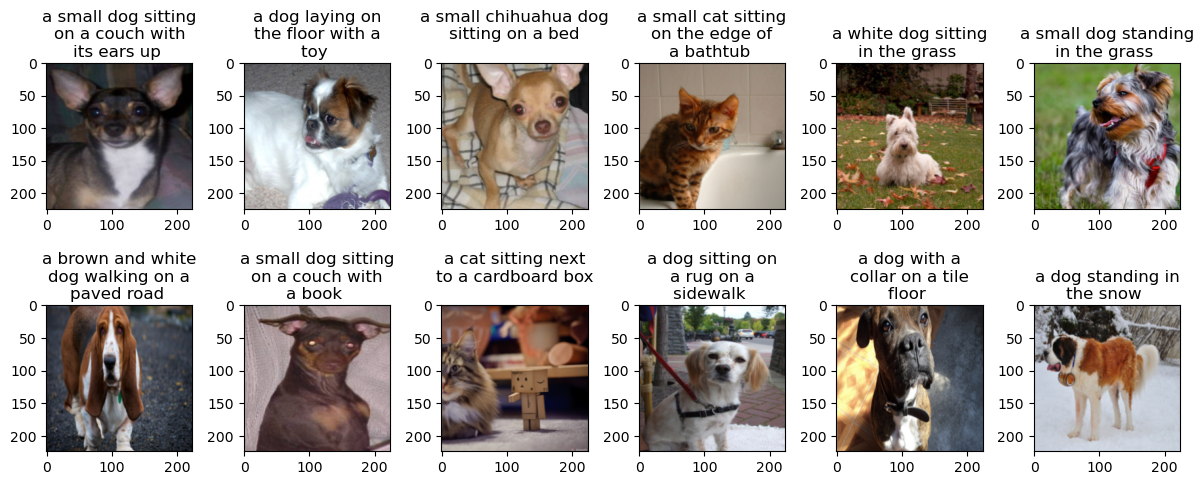

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision.transforms.v2 as transf

# Gambiarra para importar as funções de dataset feitas anteriormente
import sys
sys.path.insert(0, '../')
from M06_classificacao_de_imagens_naturais.dataset import OxfordIIITPet

class OxfordIIITPetCap(OxfordIIITPet):
    """Modifiação da classe OxfordIIITPet para retornar imagens e captions."""

    def __init__(self, root, cap_file, transforms=None):
        super().__init__(root)

        # Cria dicionário no qual a chave é o nome da imagem e o valor
        # é o caption
        text = open(cap_file).read().splitlines()
        cap_dict = {}
        for line in text:
            file, caption = line.split(',', 1)
            cap_dict[file.strip()] = caption.strip()
        
        # Para cada imagem, armazena o respectivo caption
        captions = []
        for filename in self.images:
            name = filename.stem
            captions.append(cap_dict[name])

        self.captions = captions
        self.transforms = transforms

    def __getitem__(self, idx):
        # Chama o método .__getitem__ da classe pai e ignora o target
        image, _ = super().__getitem__(idx)
        caption = self.captions[idx]

        if self.transforms is not None:
            image = self.transforms(image)

        # Retorna a imagem e o caption
        return image, caption
    
def wrap_text(text):
    """Função para quebrar o texto em linhas. Usada apenas para visualização
    dos dados."""
    
    text_split = text.split()
    for idx in range(len(text_split)):
        if (idx+1)%4==0:
            text_split[idx] += '\n'
        else:
            text_split[idx] += ' '
    wrapped_text = ''.join(text_split)

    return wrapped_text

def show_items(ds):
    '''Visualização dos itens to dataset.'''

    inds = torch.randint(0, len(ds), size=(12,))
    items = [ds[idx] for idx in inds]

    fig, axs = plt.subplots(2, 6, figsize=(12,5))
    axs = axs.reshape(-1)
    for idx in range(12):
        image, caption = items[idx]
        caption = wrap_text(caption)
        axs[idx].imshow(image.permute(1, 2, 0)/255.)
        axs[idx].set_title(caption, loc='center', wrap=True)
    fig.tight_layout()

transforms = transf.Compose([
    transf.PILToTensor(),   
    transf.RandomResizedCrop(size=(224,224), scale=(0.8,1.), ratio=(0.7,1.3)),
    transf.RandomHorizontalFlip(),
    transf.ToDtype(torch.float32),
])

ds = OxfordIIITPetCap('../data/oxford_pets', '../data/oxford_pets_captions.txt', 
                      transforms=transforms)
show_items(ds)

Vamos criar uma função collate_fn para definição dos batches. Para simplificar, não vamos criar um tensor para o texto. Para fazer isso teríamos que tokenizar o texto dentro do dataset. Vamos deixar a tokenização para o modelo de codificação do texto.

In [2]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    """Concatena imagens, mas não os textos"""

    images, texts = list(zip(*batch))
    batched_imgs = torch.stack(images, 0)

    return batched_imgs, texts

dl = DataLoader(ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
imgs, texts = next(iter(dl))

### Extração de atributos de texto

In [3]:
from model import TextEncoder

text_encoder = TextEncoder()
features = text_encoder(texts)
features.shape


torch.Size([4, 768])

### Extração de atributos de imagem

In [4]:
from torchvision.models import resnet50, ResNet50_Weights

image_encoder = resnet50(weights=ResNet50_Weights.DEFAULT)
image_encoder.fc = nn.Identity()
features = image_encoder(imgs)
features.shape

torch.Size([4, 2048])

### Modelo multimodal

Temos um codificador de imagens que extrai 2048 atributos para cada imagem de entrada e um codificador de texto que extrai 768 atributos para cada texto. Criaremos um modelo que calcula a similaridade entre esses atributos. O modelo é chamado de CLIP e foi desenvolvido pela OpenAI.

Referências:

* [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)
* [Repositório do Hugginface](https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py)


In [5]:
class Clip(nn.Module):

    def __init__(self, image_encoder, text_encoder, img_dim, text_dim,
                 temp=2.6592, dim=512):
        super().__init__()

        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        # Camadas de projeção
        self.visual_projection = nn.Linear(img_dim, dim, bias=False)
        self.text_projection = nn.Linear(text_dim, dim, bias=False)
        self.logit_scale = nn.Parameter(torch.tensor(temp)) 

    def project_images(self, imgs):
        '''Codifica imagens.'''

        image_embeds = self.image_encoder(imgs)
        image_embeds = self.visual_projection(image_embeds)
        # Normaliza os valores pela magnitude do vetor, que é a raiz quadrada 
        # da soma dos valores ao quadrado
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)

        return image_embeds
    
    def project_texts(self, texts):
        '''Codifica textos.'''

        text_embeds = self.text_encoder(texts)
        text_embeds = self.text_projection(text_embeds)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        return text_embeds

    def forward(self, imgs, texts, return_emb=False):

        image_embeds = self.project_images(imgs)
        text_embeds = self.project_texts(texts)
        
        # Similaridade de coseno. Cada linha i dessa matriz representa a 
        # similaridade entre o texto i e as imagens do batch. O elemento
        # (i,i) representa a similaridade entre o texto i e a imagem correta 
        # que corresponde a esse texto, enquanto que os demais elementos da 
        # linha correspondem a correspondências incorretas. 
        logit_scale = self.logit_scale.exp()
        logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale

        output = logits_per_text
        # Opcionalmente, retorna as projeções das imagens e textos
        if return_emb:
            output += (image_embeds, text_embeds)

        return output
    
def contrastive_loss(logits_per_text):
    '''Calcula a entropia cruzada para cada linha da matriz, considerando
    que a "classe" correta da linha i é dada pela coluna i.'''
    return nn.functional.cross_entropy(logits_per_text, torch.arange(len(logits_per_text), device=logits_per_text.device))

def clip_loss(similarity):
    '''Queremos que a matriz de similaridade possua valores altos na diagonal,
    e valores baixos fora da diagonal. Essa loss também é chamada de InfoNCE.'''

    caption_loss = contrastive_loss(similarity)
    image_loss = contrastive_loss(similarity.t())
    return (caption_loss + image_loss) / 2.0

text_encoder.requires_grad_(False)
model = Clip(image_encoder, text_encoder, img_dim=2048, text_dim=768)

logits_per_text = model(imgs, texts)
loss = clip_loss(logits_per_text)
loss

tensor(1.4244, grad_fn=<DivBackward0>)

### Zero-shot accuracy

Como o modelo envolve similaridade entre texto e imagens, é difícil medir a qualidade de forma intuitiva. Uma forma de fazer isso é verificando a capacidade do modelo de ser aplicado em outras tarefas como classificação de imagens. Como o modelo não foi treinado para tal tarefa, isso é chamado de zero-shot accuracy.

Vamos implementar uma função simples de acurácia que verifica a capacidade do modelo em classificar as imagens nas classes gato e chachorro.

In [6]:
@torch.no_grad()
def zero_shot_accuracy(model, imgs, texts, label_embeds, device):

    # Estimativa da classe correta da imagem baseado no caption
    targets = []
    for text in texts:
        if 'cat' in text or 'kitten' in text:
            target = 0
        elif 'dog' in text or 'puppy' in text:
            target = 1
        else:
            target = 2
        targets.append(target)
    targets = torch.tensor(targets, device=device)

    # Projeção das imagens
    image_embeds = model.project_images(imgs)
    # Similaridade entre cada imagem e as palavras 'cat' e 'dog'
    scores = torch.matmul(image_embeds, label_embeds.t())
    # Índice da classe mais provável
    predictions = scores.argmax(dim=1)
    # Fração das imagens da classe gato (cachorro) que são mais similares à 
    # palavra 'cat' ('dog')
    mask = targets!=2
    targets = targets[mask]
    predictions = predictions[mask]
    acc = (predictions==targets).float().mean()

    return acc

label_embeds = model.project_texts(['cat', 'dog'])
zero_shot_accuracy(model, imgs, texts, label_embeds, 'cpu')

tensor(0.)